### Expansión COVID-19: Visualizaciones atractivas con Matplotlib
Desde hace ya algunas semanas el mundo se encuentra atravesando un momento histórico en el que la mayor parte de las personas nos encontramos en cuaretena con el objetivo de ralentizar la expansión de la pandemia del coronavirus. Durante estos días, todo parece girar alrededor de este tema y este notebook no será la excepción. Me propongo utilizar información sobre la expansión del virus como hilo conductor para crear visualizaciones atractivas con la librería más común en Python, `matplotlib`.

### Pandemia de enfermedad por coronavirus 2019-2020
Solo para poner en contexto, [COVID-19](https://es.wikipedia.org/wiki/Pandemia_de_enfermedad_por_coronavirus_de_2019-2020) proviene de _"Coronavirus Disease 2019"_ , el término con el que se conoce a la enfermedad provocada por el virus _coronavirus 2 del síndrome respiratorio agudo grave (SARS-CoV-2)_. Es una enfermedad que se identificó por primera vez el 1 de diciembre de 2019 en la ciudad de Wuhan, capital de la provincia de Hubei, en la China central, cuando se reportó a un grupo de personas con neumonía de causa desconocida. La OMS la reconoció como una pandemia global el 11 de marzo de 2020. Al momento de escribir este artículo, se ha informado de más de 1.2 millones de casos de COVID-19 en más de doscientos países y territorios, lo que ha dado como resultado más de 70.500 muertes y más de 270.000 casos de recuperación.

### Los datos
Vamos a utilizar como fuente el set de datos publicado por DataHub.io -> [Novel Coronavirus 2019](https://datahub.io/core/covid-19) disponible en Github. La información fuente proviene de múltiples fuentes y se encuentra mantenida por el Center for Systems, Science and Engineering ([CSSE](https://systems.jhu.edu/)) de la Johns Hopkins University.
La principal ventaja de esta fuente es que el repositorio se auto-actualiza diariamente y podemos de esta manera tener siempre la ultima información disponible.

En muchos sitios podemos encontrar los famosos "gráficos de las curvas" de contagio donde siempre se muestran los países con mayor número de casos (típicamente Europa, algunos países de Asia y EE.UU). Lo que no había visto mucho hasta ahora, son gráficos que comparen la situación de los territorios de nuestra región, por lo que vamos a centrarnos en los principales países de Sudamérica para las primeras visualizaciones. 

In [1]:
# Cargamos librerías necesarias
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
%matplotlib inline

# Cargamos los datos y seleccionamos la información
df = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv', parse_dates=['Date'])
countries = ['Argentina', 'Brazil', 'Chile', 'Uruguay', 'Peru', 'Bolivia', 'Paraguay', 'Ecuador', 'Colombia', 'Venezuela']
df = df[df['Country'].isin(countries)]

# Creamos una columna con los casos totales 
# (Cases = Confirmed + Recovered + Deaths)
df['Cases'] = df[['Confirmed', 'Recovered', 'Deaths']].sum(axis=1)
df.tail(10)

,Date,Country,Confirmed,Recovered,Deaths,Cases
14621,2020-04-10,Argentina,1975,375,82,2432
14635,2020-04-10,Bolivia,268,2,19,289
14638,2020-04-10,Brazil,19638,173,1057,20868
14650,2020-04-10,Chile,6501,1571,65,8137
14652,2020-04-10,Colombia,2473,197,80,2750
14666,2020-04-10,Ecuador,7161,368,297,7826
14746,2020-04-10,Paraguay,129,18,6,153
14747,2020-04-10,Peru,5897,1569,169,7635
14791,2020-04-10,Uruguay,473,206,7,686
14793,2020-04-10,Venezuela,171,84,9,264


### Preparamos la información
Vamos a pivotear el DataFrame `df` para que nos queden las fechas como indice de la tabla y una columna por cada país con el total de casos hasta ese momento. A su vez, vamos a cortar el conjunto de datos para que el conteo de casos se realice desde el primer caso de la región, que se registró en Brasil el 26 de Febrero de 2020. 

In [2]:
# Reestructuramos la información
df = df.pivot(index='Date', columns='Country', values='Cases')
# countries = list(df.columns)
countries = ['Argentina', 'Bolivia', 'Brasil', 'Chile', 'Colombia', 'Ecuador', 'Paraguay', 'Perú', 'Uruguay', 'Venezuela']
covid = df.reset_index('Date')
covid.set_index('Date', inplace=True)
covid.columns = countries

# Recortamos a partir del primer caso
covid = covid.query('Date >= "2020-02-26"')

Vamos a calcular también la cantidad de casos cada 100.000 habitantes para darle otro punto de vista a la información.

_<small>Datos de población extraídos de [este artículo](https://en.wikipedia.org/wiki/List_of_countries_by_population_(United_Nations)) Wikipedia.</small>_

In [3]:
# Armamos diccionario con las poblaciones por país
populations = {'Argentina': 44361150, 'Brasil': 209469323, 'Chile': 18729160, 'Uruguay': 3449285, 'Perú': 31989260, 'Bolivia': 11353142, 'Paraguay': 6956066, 'Ecuador': 17084358, 'Colombia': 49661048, 'Venezuela': 28887118}

# Copiamos el DataFrame y lo modificamos para que muestre casos c/100.000 hab.
percapita = covid.copy()
for country in list(percapita.columns):
    percapita[country] = percapita[country]/populations[country]*100000

### Comencemos a visualizarlo
Vamos a comenzar creando una visualización que muestre la cantidad de casos totales a lo largo del tiempo.

Aquí el objetivo que buscaremos es que la visualización sea lo más atractiva posible. Para ello en primer lugar configuramos para `matplotlib` el estilo `FiveThirtyEight` y creamos un diccionario con códigos hexadecimales de colores personalizados para cada país. Almacenarlos de esta manera nos permitirá luego referenciarlos desde un bucle `for`. 

Otra customización es el formato del eje y, que llevamos a cabo con el método `matplotlib.ticker.StrMethodFormatter()` para mostrar los valores con separadores de miles. 

Más adelante, en el ciclo for, lo que hacemos es asignar las referencias a cada curva utilizando `plot.text` en el gráfico. El truco aquí es como utilizamos el indice del DataFrame para ubicar las coordenadas `x` e `y` de la etiqueta. La posición en que colocamos la misma es a la derecha del último punto registrado para cada curva: `x = covid.index[-1]` (última fecha registrada), `y = covid.loc[covid.index[-1]][country]` (valor 'y' para esa fecha). En este caso, como los casos son acumulativos, el valor de 'y' de la última fecha siempre será el máximo para el país, por lo que podemos utilizar `y = covid[country].max()`.

Finalmente agregamos como texto el título, subtitulo y la información de referencia. Aquí también el truco está en utilizar el índice y los valores máximos del DataFrame en las coordenadas `x` e `y`, para que a medida que las posiciones se vayan actualizando dinámicamente a medida que se actualicen los datos de origen.


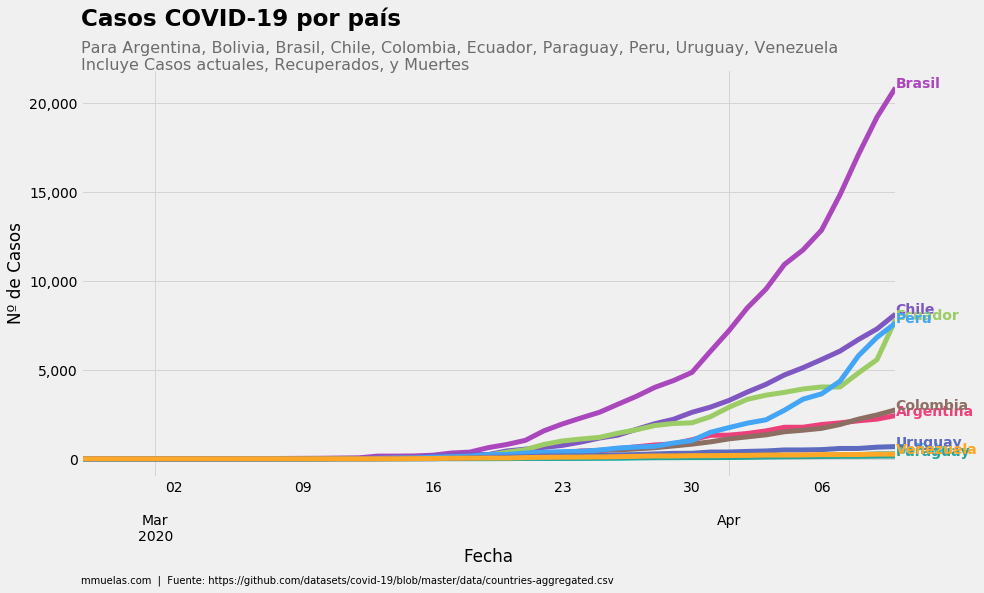

In [12]:
# Generamos colores y estilo
colors = {'Argentina': '#EC407A', 'Bolivia': '#26C6DA', 'Brasil': '#AB47BC', 'Chile': '#7E57C2', 'Colombia': '#8D6E63', 'Ecuador': '#9CCC65', 'Paraguay': '#26A69A', 'Perú': '#42A5F5', 'Uruguay': '#5C6BC0', 'Venezuela': '#FFA726'}
plt.style.use('fivethirtyeight')

# Creamos la visualización
plot = covid.plot(figsize=(13,7), color=list(colors.values()), linewidth=5, legend=False)

# Ajustamos el formato de la escala del eje y
plot.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_xlabel('Fecha')
plot.set_ylabel('Nº de Casos')

# Asignamos colores y referencias
for country in list(colors.keys()):
    plot.text(x = covid.index[-1], y = covid[country].max(), c = colors[country], s = country, weight = 'bold')

# Etiquetas
plot.text(x = covid.index[0], y = int(covid.max().max())+3500, s = "Casos COVID-19 por país", fontsize = 23, weight = 'bold')
plot.text(x = covid.index[0], y = int(covid.max().max())+1000, s = "Para Argentina, Bolivia, Brasil, Chile, Colombia, Ecuador, Paraguay, Peru, Uruguay, Venezuela\nIncluye Casos actuales, Recuperados, y Muertes", fontsize = 16, alpha = .55)
plot.text(x = percapita.index[0], y = -7000,s = 'mmuelas.com  |  Fuente: https://github.com/datasets/covid-19/blob/master/data/countries-aggregated.csv', fontsize = 10)

plt.show()

### Creamos ahora la visualización de Casos cada 100.000 habitantes
Para la seguna visualización, utilizaremos prácticamente lo mismo que en la anterior, pero reemplazando el DataFrame `covid` por `percapita`.
Los únicos ajustes necesarios fueron los offset para las coordenadas `y` de los títulos y referencias.

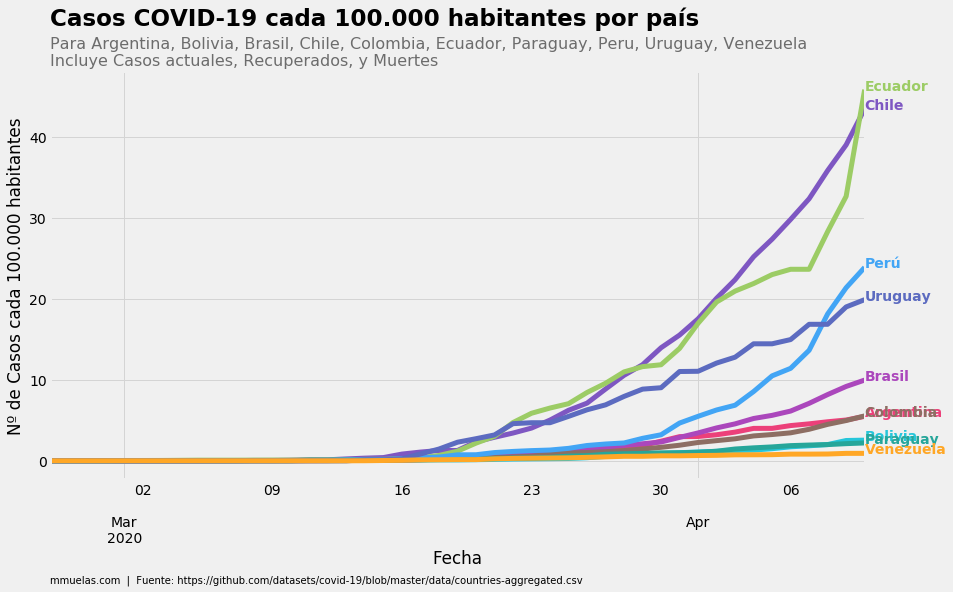

In [13]:
percapitaplot = percapita.plot(figsize=(13,7), color=list(colors.values()), linewidth=5, legend=False)

percapitaplot.grid(color='#d4d4d4')
percapitaplot.set_xlabel('Fecha')
percapitaplot.set_ylabel('Nº de Casos cada 100.000 habitantes')

for country in list(colors.keys()):
    percapitaplot.text(x = percapita.index[-1], y = percapita[country].max(), c = colors[country], s = country, weight = 'bold')

percapitaplot.text(x = percapita.index[0], y = percapita.max().max()+8, s = "Casos COVID-19 cada 100.000 habitantes por país", fontsize = 23, weight = 'bold')
percapitaplot.text(x = percapita.index[0], y = percapita.max().max()+3, s = "Para Argentina, Bolivia, Brasil, Chile, Colombia, Ecuador, Paraguay, Peru, Uruguay, Venezuela\nIncluye Casos actuales, Recuperados, y Muertes", fontsize = 16, alpha = .55)
percapitaplot.text(x = percapita.index[0], y = -15, s = 'mmuelas.com  |  Fuente: https://github.com/datasets/covid-19/blob/master/data/countries-aggregated.csv', fontsize = 10)

plt.show()